In [2]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [ ]:
# on collab: 
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [3]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import skimage as ski

from multiprocessing import Pool

from sklearn.metrics import f1_score, accuracy_score

Example for visualization

In [4]:
ds = datasets.MNIST(root = "./data", train=False, download=True, transform=T.ToTensor())

In [ ]:
for d in ds:
    print(d[0].shape, d[1])
    break

(28, 28)
RAG with 65 nodes and 186 edges


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


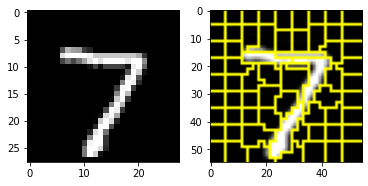

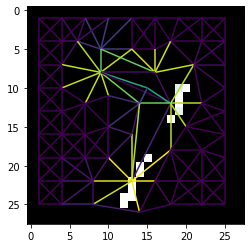

In [16]:
i = ds.data[0].numpy()
print(i.shape)
segments = slic(i, n_segments=75, compactness=0.1)
g = ski.future.graph.rag_mean_color(i, segments)
print(g)

fig, axs = plt.subplots(1,2)
axs[0].imshow(i, "gray")
segmented_img = ski.segmentation.mark_boundaries(i, segments, mode="subpixel")
axs[1].imshow(segmented_img, "gray")
ski.future.graph.show_rag(segments, g, ski.color.gray2rgb(i), edge_cmap='viridis')


In [71]:

img, y = ds[1]
_, dim0, dim1 = img.shape
img_np = img.view(dim0, dim1).numpy()
s = slic(img_np, 75, 0.1, start_label=0)
g = ski.future.graph.rag_mean_color(img_np, s)
n = g.number_of_nodes()
s1 = np.zeros([n, 1])  # for mean color and std deviation
s2 = np.zeros([n, 1])  # for std deviation
pos = np.zeros([n, 2]) # for centroid
num_pixels = np.zeros([n, 1])
for idx in range(dim0 * dim1):
        idx_i, idx_j = idx % dim0, int(idx / dim0)
        node = s[idx_i][idx_j] - 1
        s1[node][0]  += img_np[idx_i][idx_j]
        s2[node][0]  += pow(img_np[idx_i][idx_j], 2)
        pos[node][0] = (num_pixels[node] * pos[node][0] + idx_i) / (num_pixels[node] + 1)
        pos[node][1] = (num_pixels[node] * pos[node][1] + idx_j) / (num_pixels[node] + 1)
        num_pixels[node][0] += 1
edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)


In [46]:
(s1**2).shape

(65, 1)

In [72]:
x = []
s1 = s1/num_pixels
avg_color = s1
x.append(torch.from_numpy(avg_color.flatten()).to(torch.float))
s2 = s2/num_pixels
std_deviation = np.sqrt(s2 - s1*s1)
x.append(torch.from_numpy(std_deviation.flatten()).to(torch.float))
pos = torch.from_numpy(pos).to(torch.float)
x.append(pos[:,0])
x.append(pos[:,1])
data =  Data(x=torch.torch.stack(x, dim=1), edge_index=edge_index, pos=pos, y=y)

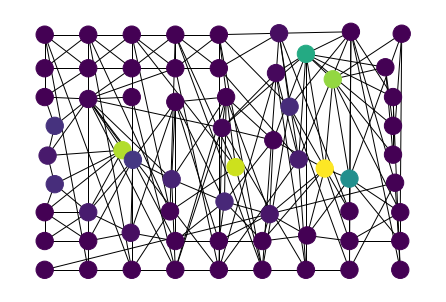

In [73]:
import networkx as nx
from torch_geometric.utils import to_networkx
to_networkx(data, to_undirected=True)
nx.draw(g, pos=dict(zip(range(65), data.pos.numpy())), node_color=data.x[:,0])
# acho que ta virado ?

In [74]:
data.y

2

In [ ]:
# x = torch.from_numpy(x).to(torch.float)
# pos = torch.from_numpy(pos).to(torch.float)
v = torch.stack([x.flatten(), pos[:,0], pos[:,1]], dim=1)
v

For each node compute
- mean color 
- geometric centroid

Edge index from skimage's RAG

SuperPixel MNIST dataset

In [3]:
class SuperPixelGraphMNIST(InMemoryDataset):
    def __init__(self, root=None, n_segments = 75, compactness = 0.1, train = True, transform = None, pre_transform = None, pre_filter = None):
        self.n_segments = n_segments
        self.compactness = compactness
        self.train = train
        self.root = root
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
    
    def loadMNIST(self, n_segments, compactness, train):
        mnist = datasets.MNIST(self.root, train=train, download=True, transform=T.ToTensor())
        data_list = []
        img_total = mnist.data.shape[0]
        dim0, dim1 = mnist.data[0].shape[0], mnist.data[0].shape[1]
        print(f'Loading {img_total} images ... w/ n_segments = {self.n_segments}')
        with Pool() as p:
            data_list = p.map(self.create_data_obj, mnist)
        print('Done')
        return self.collate(data_list)

    def create_data_obj(self, d):
            img, y = d
            _, dim0, dim1 = img.shape
            img_np = img.view(dim0, dim1).numpy()
            s = slic(img_np, self.n_segments, self.compactness, start_label=0)
            g = ski.future.graph.rag_mean_color(img_np, s)
            n = g.number_of_nodes()
            x = np.zeros([n, 1]) # mean color
            pos = np.zeros([n, 2])
            num_pixels = np.zeros([n])
            for idx in range(dim0 * dim1):
                    idx_i, idx_j = idx % dim0, int(idx / dim0)
                    node = s[idx_i][idx_j] - 1
                    x[node][0]   = (num_pixels[node] * x[node][0]   + img_np[idx_i][idx_j]) / (num_pixels[node] + 1)
                    pos[node][0] = (num_pixels[node] * pos[node][0] + idx_i) / (num_pixels[node] + 1)
                    pos[node][1] = (num_pixels[node] * pos[node][1] + idx_j) / (num_pixels[node] + 1)
                    num_pixels[node] += 1
            edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
            x = torch.from_numpy(x).to(torch.float)
            pos = torch.from_numpy(pos).to(torch.float)
            return Data(x=torch.torch.stack([x.flatten(), pos[:,0], pos[:,1]], dim=1), edge_index=edge_index, pos=pos, y=y)

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        data, slices = self.loadMNIST(self.n_segments, self.compactness, self.train)
        torch.save((data, slices), self.processed_paths[0])

In [5]:

test_ds = SuperPixelGraphMNIST(root='./test-data', train=False)
train_ds = SuperPixelGraphMNIST(root='./train-data', train=True)

In [15]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [4]:
test_ds_125 = SuperPixelGraphMNIST(root='./test-data-125', train=False, n_segments=125)
train_ds_125 = SuperPixelGraphMNIST(root='./train-data-125', train=True, n_segments=125)

In [7]:
test_ds_125[0]

Data(x=[65, 3], edge_index=[2, 186], y=[1], pos=[65, 2])

In [7]:

train_loader_125 = DataLoader(train_ds_125, batch_size=64, shuffle=True)
test_loader_125 = DataLoader(test_ds_125, batch_size=64, shuffle=True)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, data):
        super(GCN, self).__init__()
        # using architecture inspired by MNISTSuperpixels example 
        # (https://medium.com/@rtsrumi07/understanding-graph-neural-network-with-hands-on-example-part-2-139a691ebeac)
        hidden_channel_size = 64 
        self.initial_conv = GCNConv(data.num_features, hidden_channel_size)
        self.conv1 = GCNConv(hidden_channel_size, hidden_channel_size)
        self.conv2 = GCNConv(hidden_channel_size, hidden_channel_size)
        # self.conv3 = GCNConv(hidden_channel_size, data.num_features)
        self.out = nn.Linear(hidden_channel_size*2, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        # hidden = self.conv3(hidden, edge_index)
        # hidden = F.relu(hidden)
        hidden = torch.cat([global_mean_pool(hidden, batch_index),
                            global_max_pool(hidden, batch_index)], dim=1)
        out = self.out(hidden)
        return out 

In [10]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, b in enumerate(dataloader):
        b.to(device)
        pred = model(b.x, b.edge_index, b.batch)
        loss = loss_fn(pred, b.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            # print(f"loss: {loss:>7f}  [{(current*64):>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    Y, Y_pred = torch.empty(0), torch.empty(0)
    with torch.no_grad():
        for d in dataloader:
            d.to(device)
            pred = model(d.x, d.edge_index, d.batch)
            test_loss += loss_fn(pred, d.y).item()
            Y = torch.cat([Y, d.y.to('cpu')])
            Y_pred = torch.cat([Y_pred, pred.to('cpu')])

    test_loss /= num_batches
    Y_pred = torch.argmax(Y_pred, dim=1)
    accuracy = accuracy_score(Y, Y_pred)
    f1_micro = f1_score(Y, Y_pred, average='micro', labels=[0,1,2,3,4,5,6,7,8,9])
    f1_macro = f1_score(Y, Y_pred, average='macro', labels=[0,1,2,3,4,5,6,7,8,9])
    print(f"Accuracy: {accuracy:>8f}, F-measure (micro): {f1_micro:>8f}, F-measure (macro): {f1_macro:>8f}, Avg loss: {test_loss:>8f}")

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GCN(train_ds).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    print(f"Epoch {t+1}: ", end='')
    train(train_loader, model, loss_fn, optimizer, device)
    test(test_loader, model, loss_fn, device)
print("Done!")

cuda
Epoch 1: Accuracy: 0.316000, F-measure (micro): 0.316000, F-measure (macro): 0.244253, Avg loss: 1.952236
Epoch 2: Accuracy: 0.403100, F-measure (micro): 0.403100, F-measure (macro): 0.353937, Avg loss: 1.679835
Epoch 3: Accuracy: 0.431200, F-measure (micro): 0.431200, F-measure (macro): 0.399478, Avg loss: 1.624013
Epoch 4: Accuracy: 0.479600, F-measure (micro): 0.479600, F-measure (macro): 0.469785, Avg loss: 1.479309
Epoch 5: Accuracy: 0.530300, F-measure (micro): 0.530300, F-measure (macro): 0.509869, Avg loss: 1.390933
Epoch 6: Accuracy: 0.545400, F-measure (micro): 0.545400, F-measure (macro): 0.531754, Avg loss: 1.317251
Epoch 7: Accuracy: 0.557100, F-measure (micro): 0.557100, F-measure (macro): 0.544917, Avg loss: 1.284381
Epoch 8: Accuracy: 0.570400, F-measure (micro): 0.570400, F-measure (macro): 0.552391, Avg loss: 1.253337
Epoch 9: Accuracy: 0.595500, F-measure (micro): 0.595500, F-measure (macro): 0.588083, Avg loss: 1.209983
Epoch 10: Accuracy: 0.595800, F-measure (

In [12]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model125 = GCN(train_ds_125).to(device)
optimizer = torch.optim.Adam(model125.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 100
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    print(f"Epoch {t+1}: ", end='')
    train(train_loader_125, model125, loss_fn, optimizer, device)
    test(test_loader_125, model125, loss_fn, device)
print("Done!")

cuda
Epoch 1: Accuracy: 0.263200, F-measure (micro): 0.263200, F-measure (macro): 0.212337, Avg loss: 2.047886
Epoch 2: Accuracy: 0.354100, F-measure (micro): 0.354100, F-measure (macro): 0.302030, Avg loss: 1.804146
Epoch 3: Accuracy: 0.457200, F-measure (micro): 0.457200, F-measure (macro): 0.407186, Avg loss: 1.572642
Epoch 4: Accuracy: 0.499000, F-measure (micro): 0.499000, F-measure (macro): 0.472525, Avg loss: 1.444563
Epoch 5: Accuracy: 0.522200, F-measure (micro): 0.522200, F-measure (macro): 0.504212, Avg loss: 1.377015
Epoch 6: Accuracy: 0.549600, F-measure (micro): 0.549600, F-measure (macro): 0.539244, Avg loss: 1.319116
Epoch 7: Accuracy: 0.556300, F-measure (micro): 0.556300, F-measure (macro): 0.551247, Avg loss: 1.314365
Epoch 8: Accuracy: 0.562700, F-measure (micro): 0.562700, F-measure (macro): 0.549149, Avg loss: 1.284868
Epoch 9: Accuracy: 0.566400, F-measure (micro): 0.566400, F-measure (macro): 0.547665, Avg loss: 1.261786
Epoch 10: Accuracy: 0.589000, F-measure (